# Basic stochastic volatility model

This note runs a stochastic volatility model with an AR(1) latent process.

$$y_t = \epsilon_t, \quad \epsilon_t \sim N_{0,(\lambda + \sigma b)^2}, \quad t=1,\dots,\tau$$
$$b_t = \phi b_{t-1} + \nu_t\quad \nu_t \sim N_{0,1}, \quad t=2,\dots,\tau$$
$$b_1 \sim N_{0, (1+\rho^2)^{-1/2}} $$

See the graphs below and code for information about the priors and inference, which is a structured (full-rank) VI procedure.

## Preliminaries

In [1]:
# !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl >/dev/null && echo OK
# !pip3 install torchvision > /dev/null && echo OK
# !pip3 uninstall -y ptvi >/dev/null && echo OK
# !pip3 install git+https://github.com/kuperov/ptvi.git  >/dev/null && echo OK

In [2]:
from ptvi import *
import torch
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('precision', 2)
plt.rcParams['figure.figsize'] = [12, 8]

Define the true parameter values and generate data.

In [3]:
λ0, σ0, φ0 = 0., .75, 0.95
data_seed, algo_seed = 123, 123

In [4]:
torch.manual_seed(data_seed)
params = {'λ': λ0, 'σ': σ0, 'φ': φ0}
y, b = StochVolModel(input_length=100).simulate(**params)

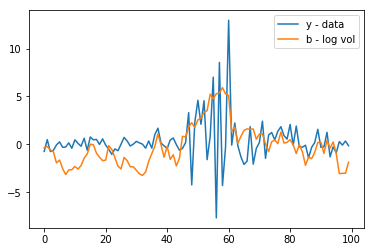

In [5]:
plt.plot(y.numpy(), label='y - data')
plt.plot(b.numpy(), label='b - log vol')
plt.legend();

## Approximate inference


In [6]:
torch.manual_seed(algo_seed)
model = StochVolModel(input_length=len(y), stochastic_entropy=True, num_draws=1)
ζ0 = torch.cat([torch.zeros(100), torch.tensor([1., 1.])])
model.u.data, model.L.data = model.initial_conditions(y, ζ0, lr=0.1)
fit = model.training_loop(y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
MAP inference with L-BGFS: Stochastic volatility model
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. ll = -447.7612
       1. ll = -194.4817
       2. ll = -179.5699
       3. ll = -177.4008
       4. ll = -176.1817
       5. ll = -176.0165
       6. ll = -176.0078
       7. ll = -176.0076
       8. ll = -176.0076
Convergence criterion met.
       8. ll = -176.0076
Completed 9 iterations in 0.26s @ 35.26 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference

Stochastic volatility model:
  - input length 100
  - Stochastic entropy term with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0

Displa

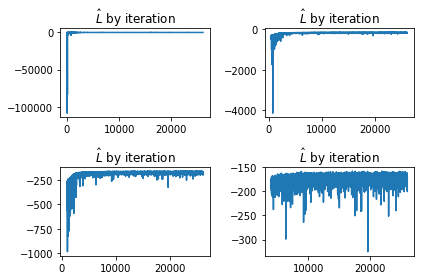

In [7]:
plt.subplot(221); fit.plot_elbos()
plt.subplot(222); fit.plot_elbos(skip=500)
plt.subplot(223); fit.plot_elbos(skip=1_000)
plt.subplot(224); fit.plot_elbos(skip=4_000)
plt.tight_layout()

In [8]:
fit.summary()

,mean,sd
σ,0.68,0.13
φ,0.88,0.05


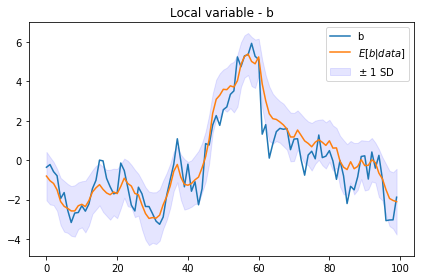

In [9]:
fit.plot_latent(b=b)

## Global variables: marginal posteriors

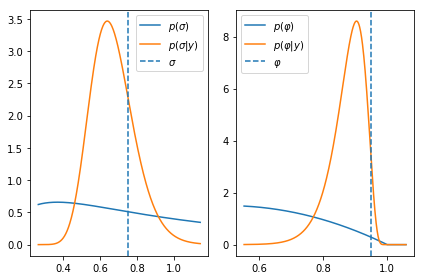

In [10]:
fit.plot_global_marginals(**params)

### Forecasts

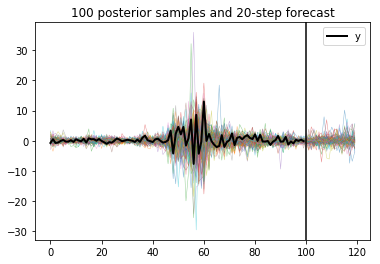

In [11]:
fit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

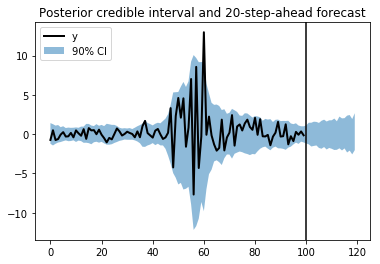

In [12]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)